In [4]:
from collections import defaultdict
import json
from operator import *
import pickle
import re

import matplotlib.pylab as pl
import numpy as np
from scipy.sparse import csr_matrix

In [2]:
input_dir = '/data/yu_gai/cfq'
output_dir = '/work/yu_gai/cfq'

# The CFQ dataset

In [3]:
df = sqlCtx.read.parquet(f'{input_dir}/dataset.parquet/')
df.columns

['complexityMeasures',
 'expectedResponse',
 'expectedResponseWithMids',
 'question',
 'questionPatternModEntities',
 'questionWithBrackets',
 'questionWithMids',
 'ruleIds',
 'ruleTree',
 'sparql',
 'sparqlPattern',
 'sparqlPatternModEntities']

## Some samples

In [5]:
n = 2
rs = df.rdd.map(lambda r: [r['questionPatternModEntities'], r['sparqlPatternModEntities']]).take(n)
for i, [question, query] in enumerate(rs):
    print(question)
    print(query)
    if i < n - 1:
        print()

Were M2 and M5 executive produced by a British executive producer of M0 and executive produced by M3 and M4
SELECT count(*) WHERE {
?x0 ns:film.producer.films_executive_produced M0 .
?x0 ns:people.person.nationality ns:m.07ssc .
M2 ns:film.film.executive_produced_by ?x0 .
M2 ns:film.film.executive_produced_by M3 .
M2 ns:film.film.executive_produced_by M4 .
M5 ns:film.film.executive_produced_by ?x0 .
M5 ns:film.film.executive_produced_by M3 .
M5 ns:film.film.executive_produced_by M4
}

Were M1 , M2 , and M3 influenced by a film producer
SELECT count(*) WHERE {
?x0 a ns:film.producer .
M1 ns:influence.influence_node.influenced_by ?x0 .
M2 ns:influence.influence_node.influenced_by ?x0 .
M3 ns:influence.influence_node.influenced_by ?x0
}


## SPARQL syntax

In [6]:
p = re.compile(r'[A-Z]+')
df.rdd.flatMap(lambda r: re.findall(p, r['sparql'])).distinct().collect()

['SELECT', 'FILTER', 'WHERE', 'DISTINCT']

In [7]:
rdd = df.rdd.map(lambda r: r['sparqlPatternModEntities'].split('\n')).cache()
rdd.map(lambda r: r[0]).distinct().collect(), rdd.map(lambda r: r[-1]).distinct().collect()  

(['SELECT count(*) WHERE {', 'SELECT DISTINCT ?x0 WHERE {'], ['}'])

## Interrogatives

In [8]:
interrogatives = df.rdd.map(lambda r: (r['questionPatternModEntities'].split(' ')[0], r['sparqlPatternModEntities'].split('\n')[0])).cache()

In [9]:
interrogatives.distinct().collect()

[('Which', 'SELECT DISTINCT ?x0 WHERE {'),
 ('Did', 'SELECT count(*) WHERE {'),
 ('Was', 'SELECT count(*) WHERE {'),
 ('Who', 'SELECT DISTINCT ?x0 WHERE {'),
 ('Were', 'SELECT count(*) WHERE {'),
 ('What', 'SELECT DISTINCT ?x0 WHERE {')]

In [14]:
interrogatives.map(lambda r: r[0]).countByValue()

defaultdict(int,
            {'Were': 19457,
             'Was': 68063,
             'Did': 43051,
             'What': 56616,
             'Which': 26466,
             'Who': 25704})

## SPARQL TRIPLES

### Triple syntax

In [16]:
triples = rdd.flatMap(lambda r: [l for l in r[1 : -1] if 'FILTER' not in l]).distinct()
p = re.compile(r'^([^ ]+) ([^ ]+) ([^ ]+)( .)?$')
triples = triples.map(lambda r: re.findall(p, r)).cache()
assert triples.map(lambda r: len(r) == 1).reduce(and_)
triples = triples.map(lambda r: r[0])
assert triples.map(lambda r: r[-1] in ['', ' .']).reduce(and_)  # conjunction only

### Subject

In [24]:
def freq(rdd):
    v, n = zip(*sorted(rdd.countByValue().items(), key=lambda x: x[1]))
    return np.array(n) / sum(n)

In [23]:
subjects = triples.map(lambda r: r[0]).cache()

In [17]:
sorted(subjects.distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 '?x5',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

### Relation

In [18]:
relations = triples.map(lambda r: r[1]).cache()

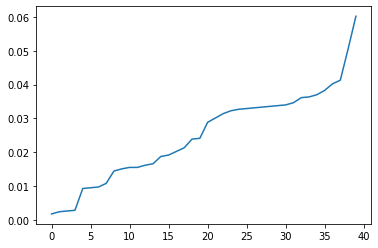

In [26]:
pl.plot(np.arange(len(rels)), freq(relations))

In [25]:
rels = sorted(triples.map(lambda r: r[1]).distinct().collect())
rels

['^ns:people.person.gender',
 '^ns:people.person.nationality',
 'a',
 'ns:business.employer.employees/ns:business.employment_tenure.person',
 'ns:film.actor.film/ns:film.performance.character',
 'ns:film.actor.film/ns:film.performance.film',
 'ns:film.cinematographer.film',
 'ns:film.director.film',
 'ns:film.editor.film',
 'ns:film.film.cinematography',
 'ns:film.film.costume_design_by',
 'ns:film.film.directed_by',
 'ns:film.film.distributors/ns:film.film_film_distributor_relationship.distributor',
 'ns:film.film.edited_by',
 'ns:film.film.executive_produced_by',
 'ns:film.film.film_art_direction_by',
 'ns:film.film.prequel',
 'ns:film.film.produced_by|ns:film.film.production_companies',
 'ns:film.film.sequel',
 'ns:film.film.starring/ns:film.performance.actor',
 'ns:film.film.written_by',
 'ns:film.film_art_director.films_art_directed',
 'ns:film.film_costumer_designer.costume_design_for_film',
 'ns:film.film_distributor.films_distributed/ns:film.film_film_distributor_relationship.f

### Object

In [11]:
sorted(triples.map(lambda r: r[2]).distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 '?x5',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'ns:business.employer',
 'ns:fictional_universe.fictional_character',
 'ns:film.actor',
 'ns:film.cinematographer',
 'ns:film.director',
 'ns:film.editor',
 'ns:film.film',
 'ns:film.film_art_director',
 'ns:film.film_costumer_designer',
 'ns:film.film_distributor',
 'ns:film.producer',
 'ns:film.production_company',
 'ns:film.writer',
 'ns:m.02zsn',
 'ns:m.0345h',
 'ns:m.03_3d',
 'ns:m.03rjj',
 'ns:m.059j2',
 'ns:m.05zppz',
 'ns:m.06mkj',
 'ns:m.07ssc',
 'ns:m.09c7w0',
 'ns:m.0b90_r',
 'ns:m.0d05w3',
 'ns:m.0d060g',
 'ns:m.0d0vqn',
 'ns:m.0f8l9c',
 'ns:people.person']

In [12]:
sorted(triples.filter(lambda r: r[1] != 'a').map(lambda r: r[2]).distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 '?x5',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'ns:m.02zsn',
 'ns:m.0345h',
 'ns:m.03_3d',
 'ns:m.03rjj',
 'ns:m.059j2',
 'ns:m.05zppz',
 'ns:m.06mkj',
 'ns:m.07ssc',
 'ns:m.09c7w0',
 'ns:m.0b90_r',
 'ns:m.0d05w3',
 'ns:m.0d060g',
 'ns:m.0d0vqn',
 'ns:m.0f8l9c']

In [30]:
triples.take(1)

[('M2', 'ns:film.film.directed_by', 'M1', ' .')]

In [13]:
triples.filter(lambda r: r[1] != 'a' and r[2].startswith('ns')).map(lambda r: r[1]).distinct().collect()

['ns:people.person.gender', 'ns:people.person.nationality']

### "Instance of" triples

In [35]:
is_ = triples.filter(lambda r: r[1] == 'a').distinct()

#### Entities

In [37]:
sorted(is_.map(lambda r: r[0]).distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 '?x5',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6']

#### Concepts

In [38]:
sorted(is_.map(lambda r: r[2]).distinct().collect())

['ns:business.employer',
 'ns:fictional_universe.fictional_character',
 'ns:film.actor',
 'ns:film.cinematographer',
 'ns:film.director',
 'ns:film.editor',
 'ns:film.film',
 'ns:film.film_art_director',
 'ns:film.film_costumer_designer',
 'ns:film.film_distributor',
 'ns:film.producer',
 'ns:film.production_company',
 'ns:film.writer',
 'ns:people.person']

## SPARQL Filters

In [17]:
filters = rdd.flatMap(lambda r: [l for l in r if 'FILTER' in l]).distinct()
p = re.compile(r'^FILTER \( ([^ ]+) != ([^ ]+) \)( .)?$')  # not equal only
xs = filters.map(lambda r: re.findall(p, r)).cache()
assert xs.map(lambda r: len(r) == 1).reduce(and_)
assert xs.map(lambda r: r[0][-1] in ['', ' .']).reduce(and_)

### LHS

In [18]:
sorted(xs.map(lambda r: r[0][0]).distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7']

### RHS

In [19]:
sorted(xs.map(lambda r: r[0][1]).distinct().collect())

['?x0',
 '?x1',
 '?x2',
 '?x3',
 '?x4',
 '?x5',
 'M0',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8']

## Preprocessing

In [20]:
split_ids = !ls {input_dir}/splits | grep json
for split_id in [s.replace('.json', '') for s in split_ids]:
    split = json.load(open(f'{input_dir}/splits/{split_id}.json'))
    np.savez(f'{output_dir}/splits/{split_id}', **{k : np.array(v) for k, v in split.items()})
    print(split_id, len(split['trainIdxs']), len(split['devIdxs']), len(split['testIdxs']), df.count())

mcd1 95743 11968 11968 239357
mcd2 95743 11968 11968 239357
mcd3 95743 11968 11968 239357
query_complexity_split 100654 9512 9512 239357
query_pattern_split 94600 12489 12589 239357
question_complexity_split 98999 10339 10340 239357
question_pattern_split 95654 12115 11909 239357
random_split 95744 11967 11967 239357


In [21]:
p = re.compile(r"^([A-Za-z0-9,']+[ ]?)+$")
df.rdd.map(lambda r: re.match(p, r['questionPatternModEntities']).string).zip(df.rdd.map(lambda r: r['questionPatternModEntities'])).map(lambda r: r[0] == r[1]).reduce(and_)

True

In [22]:
d = {}

In [23]:
get = lambda rdd, i: rdd.map(lambda r: r[i])
collect = lambda rdd: np.array(rdd.collect())
fcollect = lambda rdd: np.array(rdd.flatMap(lambda r: r).collect())

In [24]:
SEP = '[SEP]'
PAD = '[PAD]'
def mapper(r):
    toks = r['questionPatternModEntities'].split(' ')
    entities = sorted(set(re.findall(r'M[0-0]', r['questionPatternModEntities'])))
    variables = sorted(set(re.findall(r'\?x[0-9]', r['sparqlPatternModEntities'])))
    concepts = []
    for line in r['sparqlPatternModEntities'].split('\n')[1 : -1]:
        if 'FILTER' not in line:
            [[concept, *_]] = re.findall(r'^[^ ]+ [^ ]+ ([^ ]+)( .)?$', line)
            if concept.startswith('ns:'):
                concepts.append(concept)
    concepts = sorted(set(concepts))
    seq = toks + [SEP] + concepts + [SEP] + variables
    isconcept = len(toks) * [False] + len(concepts) * [True] + len(variables) * [False]
    isvariable = len(toks) * [False] + len(concepts) * [False] + len(variables) * [True]
    return seq, isconcept, isvariable

rdd = df.rdd.map(mapper).cache()
seq_rdd, isconcept_rdd, isvariable_rdd = get(rdd, 0).cache(), get(rdd, 1), get(rdd, 2)
idx2tok = seq_rdd.flatMap(lambda r: r).distinct().collect() + [SEP, PAD]
tok2idx = dict(map(reversed, enumerate(idx2tok)))

d['n_tok'] = np.array(seq_rdd.map(len).collect())
d['seq'] = fcollect(seq_rdd.map(lambda r: [tok2idx[tok] for tok in r]))
d['isconcept'], d['isvariable'] = fcollect(isconcept_rdd), fcollect(isvariable_rdd)

In [25]:
entities = sorted(tok for tok in idx2tok if re.match(r'^M[0-9]$', tok))
concepts = sorted(tok for tok in idx2tok if tok.startswith('ns:'))
variables = sorted(tok for tok in idx2tok if re.match(r'^\?x[0-9]$', tok))
sp_toks = sc.broadcast(set(entities + concepts + variables))
def mapper(r):
    d = defaultdict(list)
    for i, tok in enumerate(r):
        if tok in sp_toks.value:
            d[tok].append(i)

    n = len(d)
    n_idx = [len(d[k]) for k in sorted(d)]
    idx = sum((d[k] for k in sorted(d)), [])

    return n, n_idx, idx

rdd = seq_rdd.map(mapper).cache()
d['n'] = collect(get(rdd, 0))
d['n_idx'] = fcollect(get(rdd, 1))
d['idx'] = fcollect(get(rdd, 2))

In [26]:
def mapper(r):
    src, rel, dst = [], [], []
    for line in r['sparqlPatternModEntities'].split('\n')[1 : -1]:
        if 'FILTER' in line:
            [[src_, dst_, *_]] = re.findall(r'^FILTER \( ([^ ]+) != ([^ ]+) \)( .)?$', line)
            src.append(src_)
            rel.append('!=')
            dst.append(dst_)
        else:
            [[src_, rel_, dst_, *_]] = re.findall(r'^([^ ]+) ([^ ]+) ([^ ]+)( .)?$', line)
            src.append(src_)
            rel.append(rel_)
            dst.append(dst_)

    u, inv = np.unique(src + dst, return_inverse=True)
    src, dst = np.split(np.arange(len(u))[inv], 2)
    return src, rel, dst

rdd = df.rdd.map(mapper).cache()
d['src'], d['dst'] = fcollect(get(rdd, 0)), fcollect(get(rdd, 2))
rel_rdd = get(rdd, 1).cache()
d['m'] = collect(rel_rdd.map(len))
rel_rdd = rel_rdd.flatMap(lambda r: r).cache()
idx2rel = sorted(rel_rdd.distinct().collect())
rel2idx = {rel : idx for idx, rel in enumerate(idx2rel)}
d['rel'] = collect(rel_rdd.map(lambda r: rel2idx[r]))

In [27]:
pickle.dump([idx2tok, tok2idx], open(f'{output_dir}/vocab.pickle', 'wb'))
pickle.dump([idx2rel, rel2idx], open(f'{output_dir}/rel-vocab.pickle', 'wb'))
np.savez(f'{output_dir}/data', **d)